# Context

The goal of this **project** is to **forecast** the daily average temperature (**tavg**) with a small margin of error within a window of **at least 30 days**. This notebook aims to generate inputs for the next phase: modeling.

Given the project's objectives, **this notebook** is **divided into two phases**. In the first phase, we will **explore potential time series modeling** techniques, and in the second phase, we will **investigate the use of ML methods** to model the **residuals** from the time series forecasting phase using the remaining variables.

# Data Source
The data used in this notebook was generated from the "sanity_check.ipynb" notebook.

- **Data:** 29/11/2024
- **Localização:** ../data/wrangle

# Set up

In [1]:
## Base
import numpy as np
import pandas as pd
import os

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *
from config import *

In [2]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

In [3]:
from scipy.stats import boxcox
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Data

In [4]:
weather_df = pd.read_parquet('../data/wrangle/weather_sanitized.parquet')
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
2184,2024-12-16,280.8,0.6,0.0,5.2,1014.1,9.4,Southwest
2185,2024-12-17,275.5,0.0,0.0,3.9,1023.3,3.2,West
2186,2024-12-18,273.5,0.0,0.0,4.7,1026.2,5.6,Northwest
2187,2024-12-19,272.4,0.8,0.0,3.4,1022.8,3.9,South
2188,2024-12-20,273.0,1.5,25.0,6.1,1022.7,6.5,North


<class 'pandas.core.frame.DataFrame'>
Index: 2189 entries, 0 to 2188
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       2189 non-null   datetime64[ns]
 1   tavg       2189 non-null   float64       
 2   prcp       2189 non-null   float64       
 3   snow       2189 non-null   float64       
 4   wspd       2189 non-null   float64       
 5   pres       2189 non-null   float64       
 6   tamp       2189 non-null   float64       
 7   wcardinal  2189 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 139.3 KB


# Time Series
Since the goal is to forecast "tavg" with a long prediction horizon, **models** that do **not leverage the seasonality** of the data, such as the ARIMA model, **may not be ideal**.
Our time series, as observed during the data sanitization process, does not exhibit a significant trend. Therefore, we will **begin our analysis** with a focus on **forecasting** the **seasonal component**.

# Seasonal component
The target variable exhibits **seasonal variability**, indicating non-stationarity. **To address** this, **two strategies** will be explored:

- **Stationarity Transformation**: We will test whether applying transformations such as differencing, seasonal differencing, or log-transformation can **make the series stationary**. If successful, the SARIMA method with annual seasonality may be a suitable approach.
- **Harmonic Regression**: This method, which does not assume stationarity, will also be evaluated as it may provide robust results in capturing the seasonal patterns.

## Transformações

### log-transformation

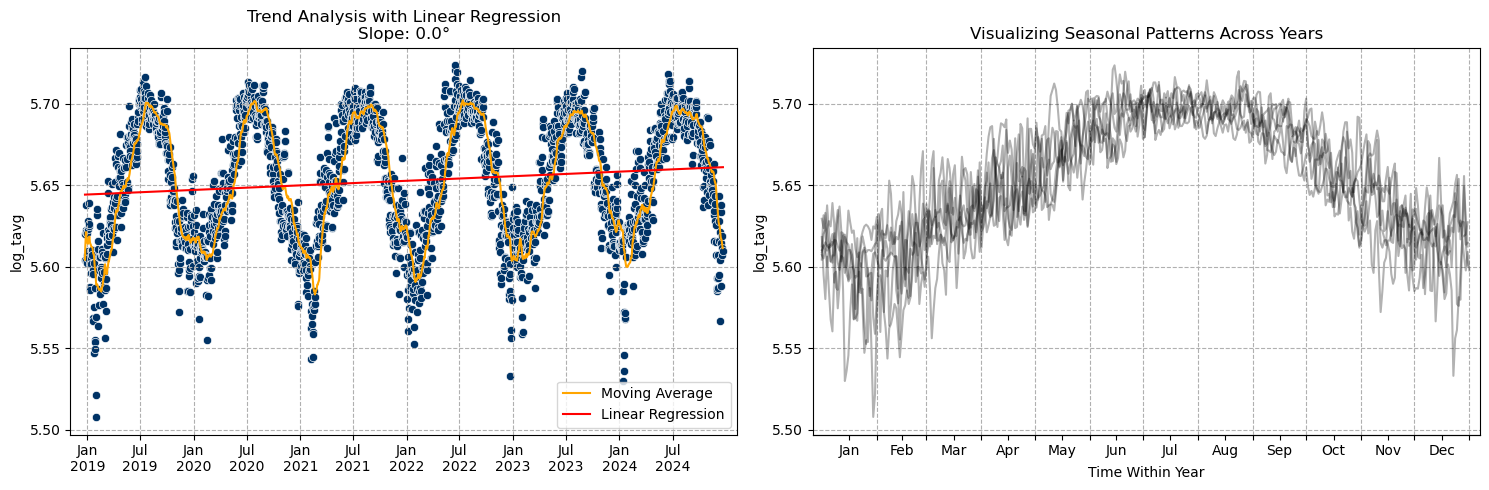

Augmented Dickey-Fuller (ADF) - p-value: 9.14%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [5]:
weather_df['log_tavg'] = np.log(weather_df['tavg'])
ts_quick_insights(weather_df['log_tavg'], weather_df['time'])
stationary_tests(weather_df['log_tavg'].dropna())

Log-transformation failed to transform the data into a stationary series.#######

### Difference

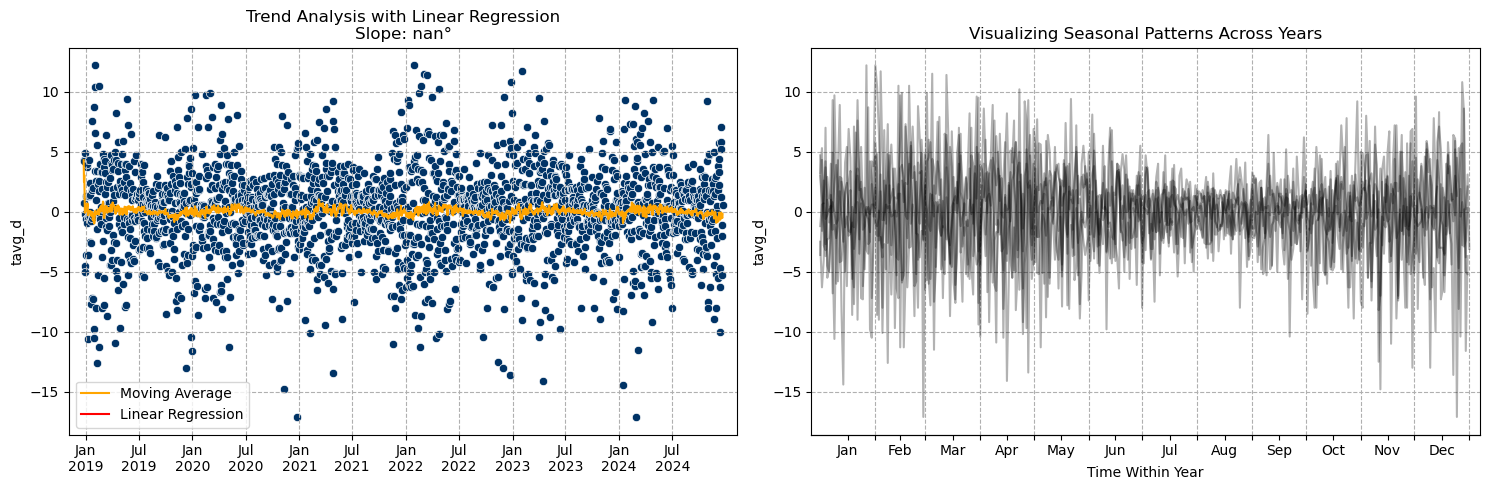

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [6]:
weather_df['tavg_d'] = [np.nan] + np.diff(weather_df['tavg']).tolist()
ts_quick_insights(weather_df['tavg_d'], weather_df['time'])
stationary_tests(weather_df['tavg_d'].dropna())

**Differencing successfully transformed** the data into a **stationary series**; however, based on the graph, it **appears that the seasonal information was lost**. This outcome is quite common for this type of transformation. **To confirm, we will** use the **PACF** and **ACF** plots.

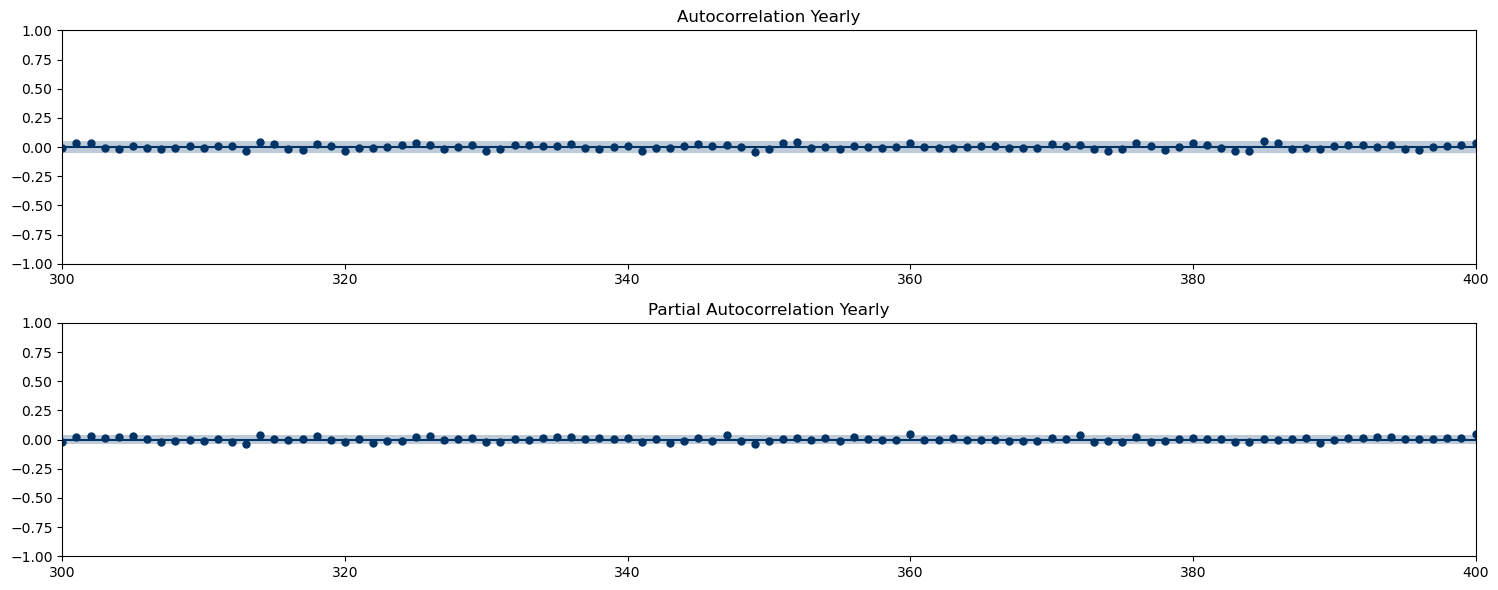

In [7]:
plot_acf_pacf(weather_df['tavg_d'].dropna(), 'seasonal')

As seen in the **graph above**, the **transformation resulted** in the **loss of seasonality**. Therefore, it is **not a good transformation** given the project's objective.

### Seasonal difference

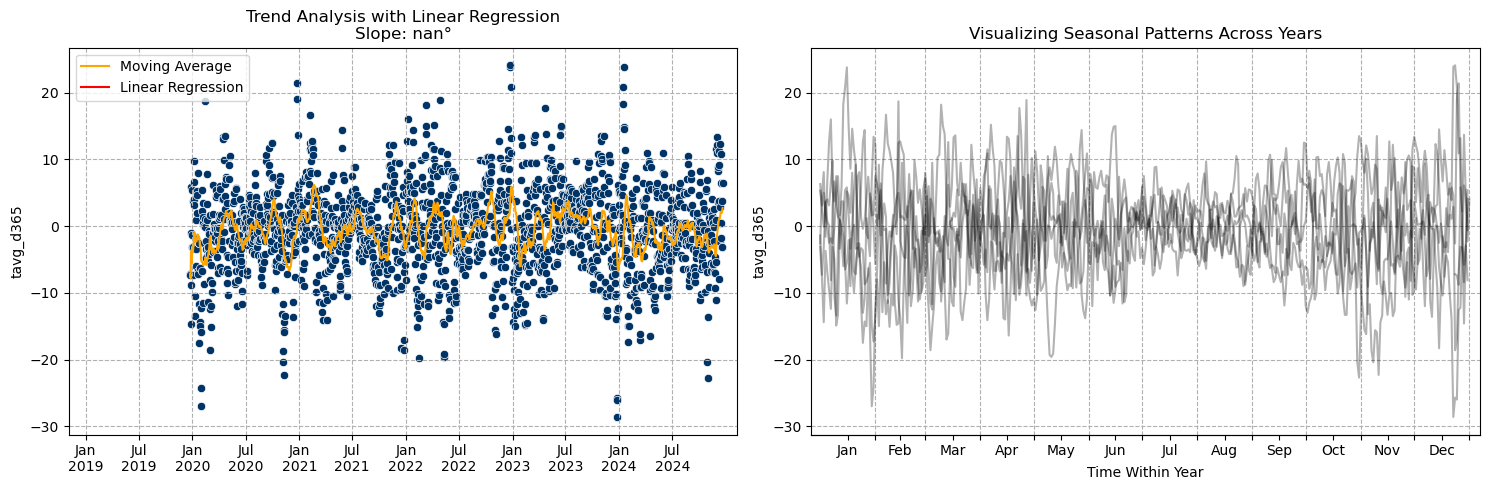

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [8]:
weather_df['tavg_d365'] = weather_df['tavg'].shift(365) - weather_df['tavg']
ts_quick_insights(weather_df['tavg_d365'], weather_df['time'])
stationary_tests(weather_df['tavg_d365'].dropna())

The **seasonal differencing successfully** transformed the data into a **stationary series**; however, the **seasonal information may have been lost**. We used the **PACF and ACF plots** to confirm.

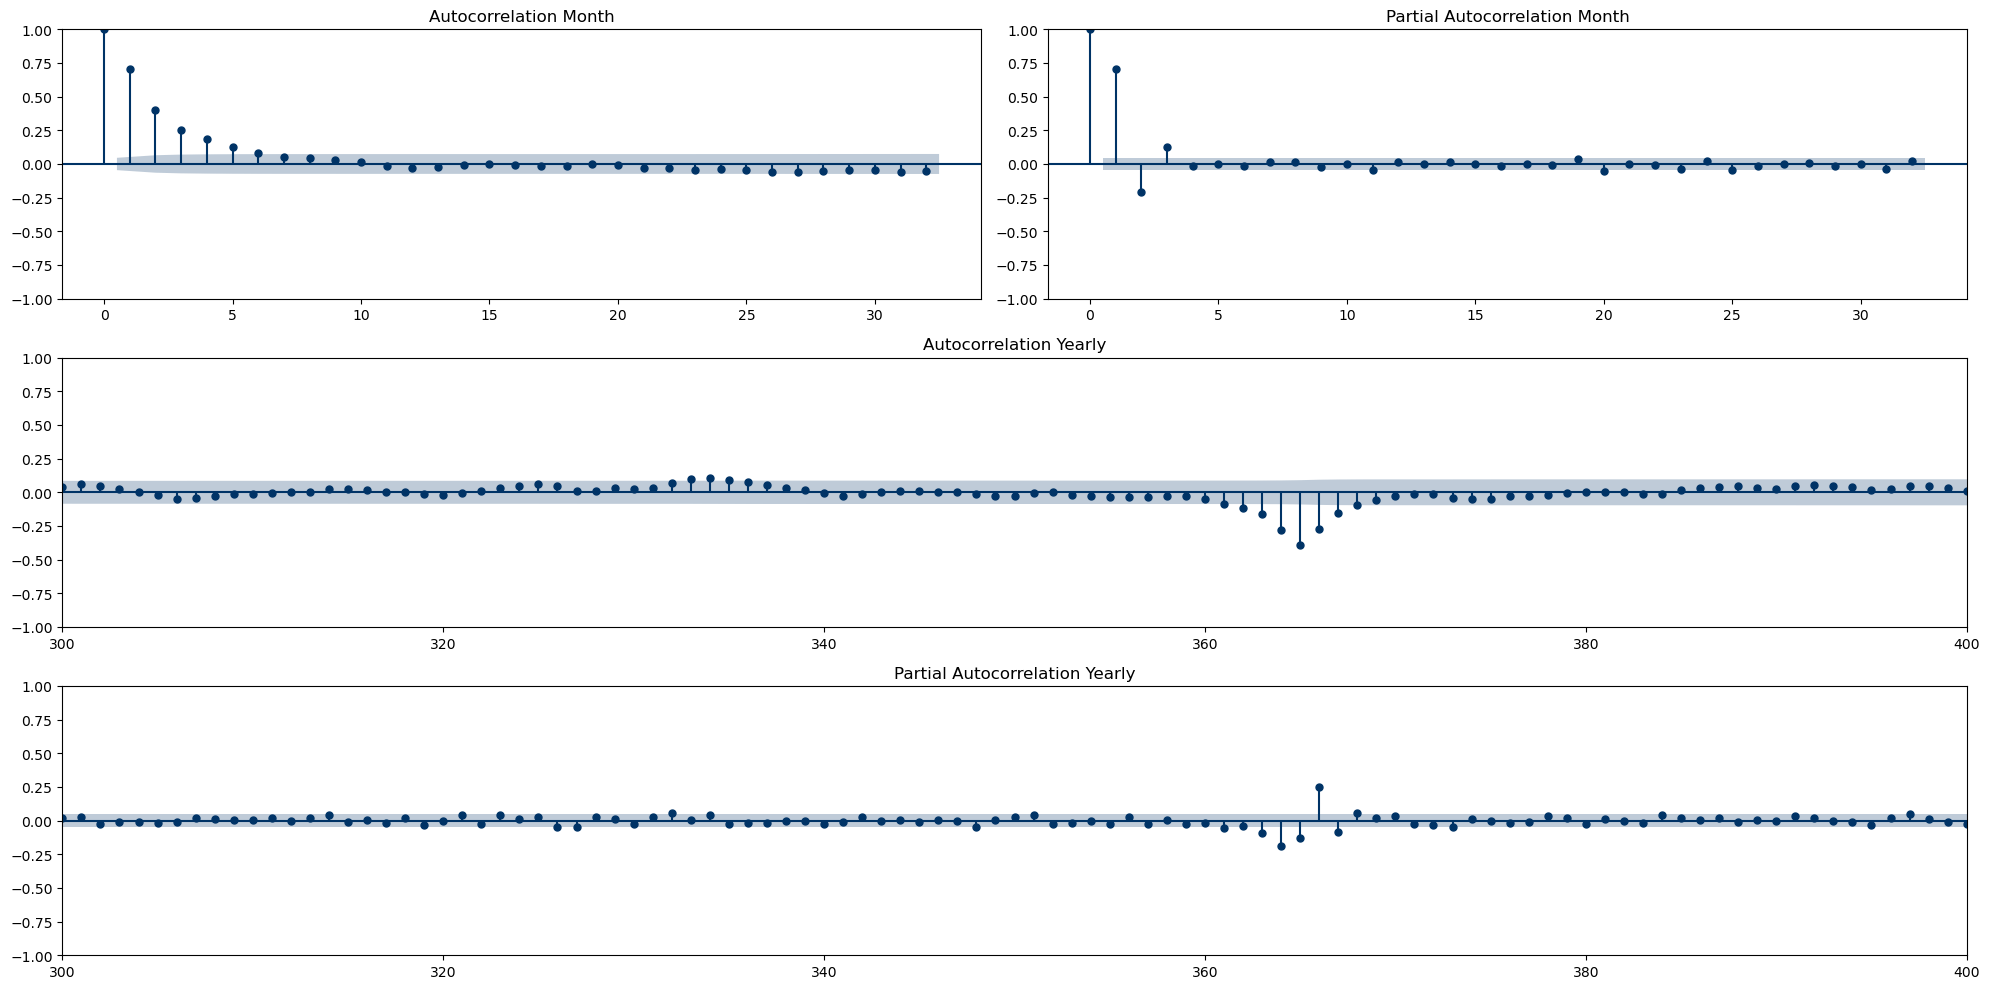

In [9]:
plot_acf_pacf(weather_df['tavg_d365'].dropna(), 'both')

Felizmente, a sazonalidade não se perdeu com a transformação porém, pelo gráfico ACF os dados aparentam não estar mais estacionários e isso, provávelmente, se dá pois não atacamos o problema da variância sazonal. Com isto em mente vamos misturar dois métodos, log-transformação e diferenciação sazonal visto que a log transformação tende a normalizar a variancia.#######

### Box-Cox

In [10]:
weather_df['tavg_boxcox'], lambda_opt = boxcox(weather_df['tavg'])

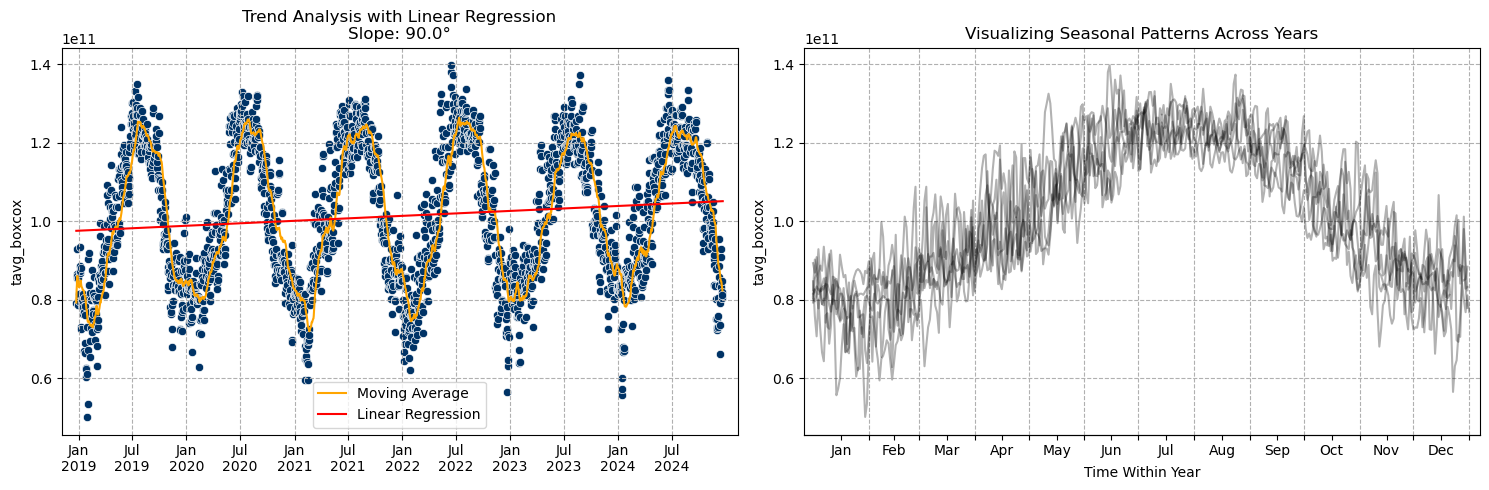

Augmented Dickey-Fuller (ADF) - p-value: 12.62%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [11]:
ts_quick_insights(weather_df['tavg_boxcox'], weather_df['time'])
stationary_tests(weather_df['tavg_boxcox'].dropna())

Com isso concluimos que modelos da familia SARIMA não serão aplicados, visto que os dados são não estacionários

## Harmonic Regression

Os dados aparentam ter uma variância sazonal forte, portanto uma transformação simples como Log-Transformation, Difference, Seasonal Difference e Box-Cox. Portanto utilizaremos uma combinação de regressão harmonica para modelar a sazonalidade e GARCH para modelar a variância dos dados.

In [13]:
weather_df.drop(columns=['log_tavg', 'tavg_d', 'tavg_d365', 'tavg_boxcox'], inplace=True)

### Modelagem

In [14]:
t = np.arange(0, len(weather_df))
X = np.column_stack([np.sin(2 * np.pi * t / 365), np.cos(2 * np.pi * t / 365)])
X = sm.add_constant(X)  # Adicionando intercepto à regressão

# Ajustando o modelo de regressão harmônica
model = sm.OLS(weather_df['tavg'].dropna(), X).fit()

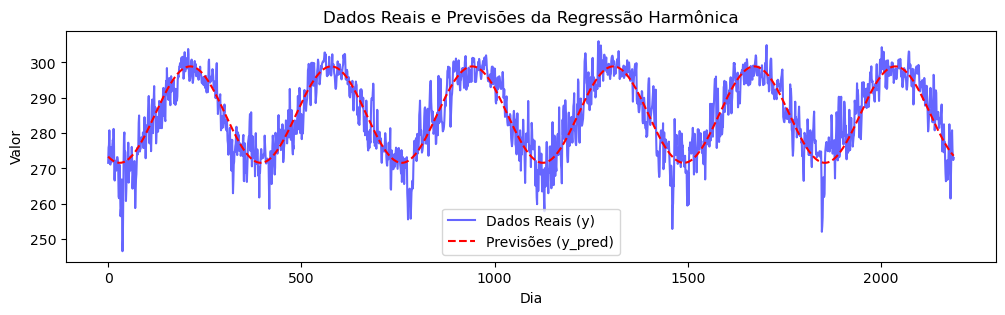

                            OLS Regression Results                            
Dep. Variable:                   tavg   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     4578.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:18:15   Log-Likelihood:                -6498.9
No. Observations:                2189   AIC:                         1.300e+04
Df Residuals:                    2186   BIC:                         1.302e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        285.2424      0.101   2830.796      0.0

In [16]:
# Gerando as previsões do modelo
weather_df['tavg_sazonal'] = model.predict(X)

# Visualizando os dados reais e as previsões
plt.figure(figsize=(12, 3))
plt.plot(t, weather_df['tavg'].dropna(), label='Dados Reais (y)', color='blue', alpha=0.6)
plt.plot(t, weather_df['tavg_sazonal'], label='Previsões (y_pred)', color='red', linestyle='--')
plt.title('Dados Reais e Previsões da Regressão Harmônica')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Resultados da regressão
print(model.summary())

### Modelagem Residuos

ShapiroResult(statistic=0.9884404044627658, pvalue=2.7661444012206697e-12)
Média: -4.0166925671036016e-13


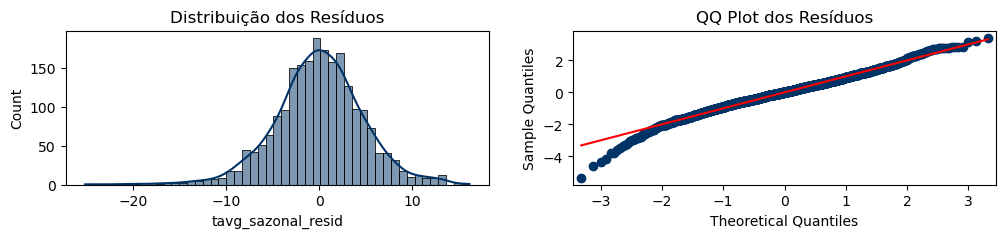

Estatística de Breusch-Pagan: 128.62878531627985, p-valor: 1.171154419502809e-28
Estatística do ADF: -17.147860301018646, p-valor: 6.974452468915051e-30


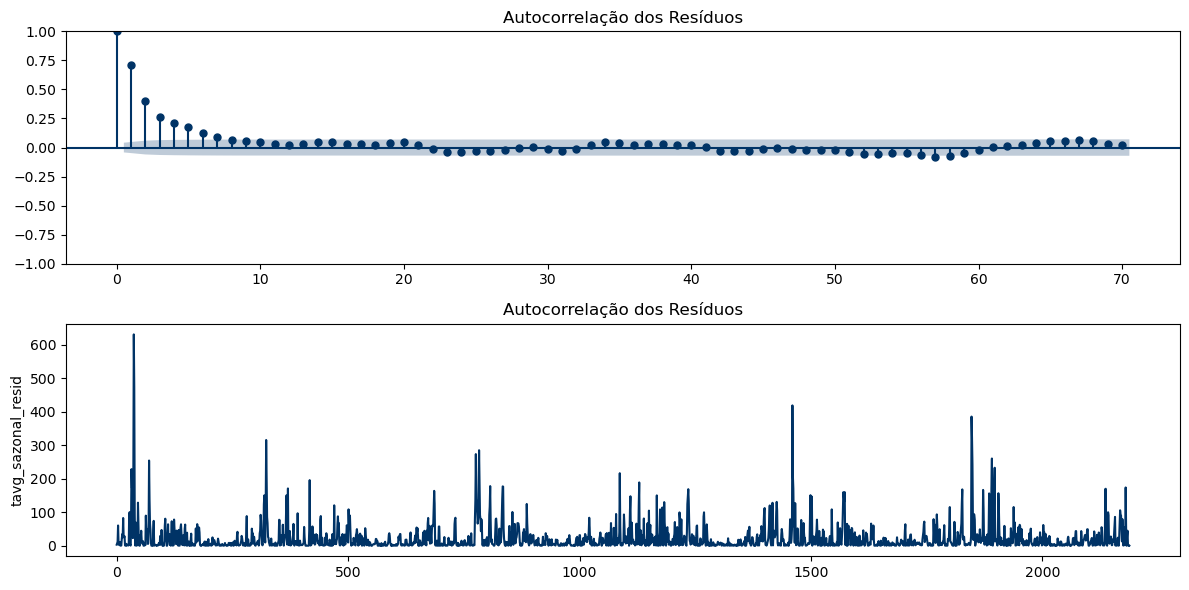

In [41]:
# Teste de normalidade dos resíduos (Shapiro-Wilk)
weather_df['tavg_sazonal_resid'] = model.resid

print(shapiro(weather_df['tavg_sazonal_resid']))
print("Média:", np.mean(weather_df['tavg_sazonal_resid']))

fig, ax =plt.subplots(1, 2, figsize=(12, 2))

sns.histplot(weather_df['tavg_sazonal_resid'], kde=True, ax=ax[0])
ax[0].set_title('Distribuição dos Resíduos')

# QQ plot dos resíduos
qqplot(weather_df['tavg_sazonal_resid'], line='s', fit=True, ax=ax[1])
ax=ax[1].set_title('QQ Plot dos Resíduos')
plt.show()

# Teste de heterocedasticidade (Breusch-Pagan)
bp_test = het_breuschpagan(weather_df['tavg_sazonal_resid'], X)
print(f"Estatística de Breusch-Pagan: {bp_test[0]}, p-valor: {bp_test[1]}")

# Teste de ADF (para verificar estacionaridade)
adf_test = adfuller(weather_df['tavg_sazonal_resid'])
print(f"Estatística do ADF: {adf_test[0]}, p-valor: {adf_test[1]}")

# Gráfico de autocorrelação dos resíduos
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(weather_df['tavg_sazonal_resid'], lags=70, ax=ax[0])
ax[0].set_title('Autocorrelação dos Resíduos')
sns.lineplot(weather_df['tavg_sazonal_resid']**2, ax=ax[1])
ax[1].set_title('Autocorrelação dos Resíduos')
plt.tight_layout()
plt.show()

Dados Trimm

In [100]:
l_limit, u_limit = np.quantile(weather_df['tavg_sazonal_resid'], [0.01, 0.99])
resids_trim = pd.Series([r for r in weather_df['tavg_sazonal_resid'] if (r >= l_limit) & (r <= u_limit)])
l_limit, u_limit

(-12.337849763385378, 12.033709208832839)

ShapiroResult(statistic=0.9981445139038084, pvalue=0.014862488134912939)
Média: 0.02898122857943624


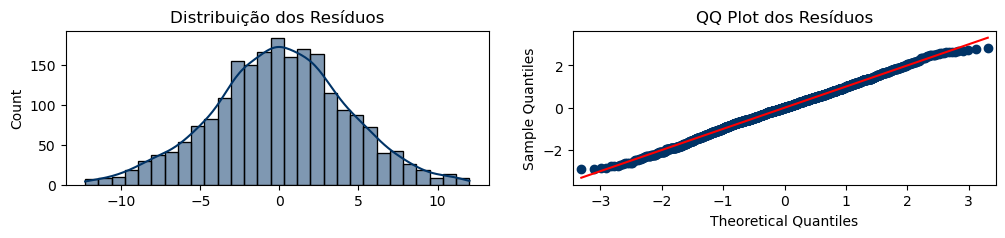

Estatística do ADF: -17.982490171259577, p-valor: 2.7717639726657998e-30


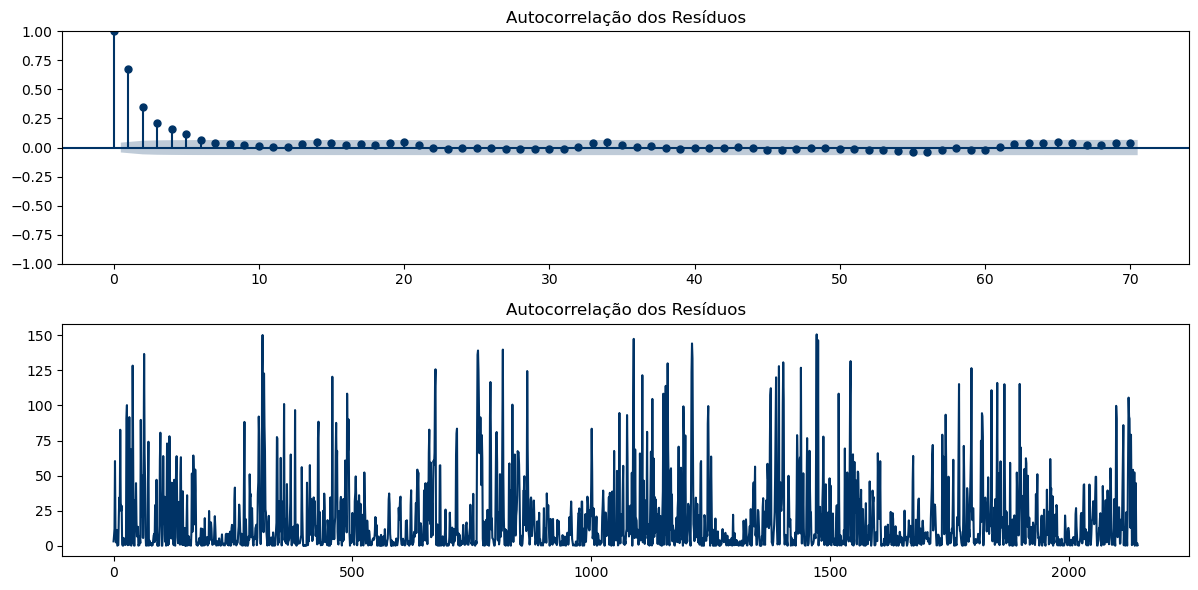

In [101]:
print(shapiro(resids_trim))
print("Média:", np.mean(resids_trim))

fig, ax =plt.subplots(1, 2, figsize=(12, 2))

sns.histplot(resids_trim, kde=True, ax=ax[0])
ax[0].set_title('Distribuição dos Resíduos')

# QQ plot dos resíduos
qqplot(resids_trim, line='s', fit=True, ax=ax[1])
ax=ax[1].set_title('QQ Plot dos Resíduos')
plt.show()

# Teste de ADF (para verificar estacionaridade)
adf_test = adfuller(resids_trim)
print(f"Estatística do ADF: {adf_test[0]}, p-valor: {adf_test[1]}")

# Gráfico de autocorrelação dos resíduos
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(resids_trim, lags=70, ax=ax[0])
ax[0].set_title('Autocorrelação dos Resíduos')
sns.lineplot(resids_trim**2, ax=ax[1])
ax[1].set_title('Autocorrelação dos Resíduos')
plt.tight_layout()
plt.show()

### GARCH

Arch test

- Ha:e2t=α0+α1e2t−1+…+αme2t−m+ut,
- H0:α0=α1=…=αm=0.

In [44]:
from statsmodels.stats.diagnostic import het_arch
lm, lmpval, fval, fpval = het_arch(weather_df['tavg_sazonal_resid'])
lmpval, fpval

(3.822957778706455e-161, 2.1333693347526924e-200)

In [46]:
pip install arch

  Using cached arch-7.2.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached arch-7.2.0-cp312-cp312-win_amd64.whl (926 kB)
Note: you may need to restart the kernel to use updated packages.


    ipywidgets (>=7.0.0cloudpickle>=0.2.2)
               ~~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
from arch import arch_model
garch_mod = arch_model(weather_df['tavg_sazonal_resid'], mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1166434520.4860692
Iteration:      2,   Func. Count:     11,   Neg. LLF: 6579.786873631792
Iteration:      3,   Func. Count:     16,   Neg. LLF: 6206.786374188466
Iteration:      4,   Func. Count:     20,   Neg. LLF: 6209.817058915933
Iteration:      5,   Func. Count:     25,   Neg. LLF: 6204.648286832387
Iteration:      6,   Func. Count:     29,   Neg. LLF: 6204.417890667692
Iteration:      7,   Func. Count:     33,   Neg. LLF: 6204.280323159036
Iteration:      8,   Func. Count:     37,   Neg. LLF: 6204.037302651939
Iteration:      9,   Func. Count:     41,   Neg. LLF: 6203.999067489898
Iteration:     10,   Func. Count:     45,   Neg. LLF: 6203.993944161751
Iteration:     11,   Func. Count:     49,   Neg. LLF: 6203.993598937559
Iteration:     12,   Func. Count:     53,   Neg. LLF: 6203.993577407364
Iteration:     13,   Func. Count:     57,   Neg. LLF: 6203.993575955679
Iteration:     14,   Func. Count:     60,   Neg. LLF: 6203.9935

In [48]:
res_garch

                       Zero Mean - GARCH Model Results                        
Dep. Variable:     tavg_sazonal_resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6203.99
Distribution:                  Normal   AIC:                           12414.0
Method:            Maximum Likelihood   BIC:                           12431.1
                                        No. Observations:                 2189
Date:                Wed, Feb 12 2025   Df Residuals:                     2189
Time:                        21:39:12   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          7.5492      1.050      7.188  6.569e-13    [  

## ML Methods